# Figure Generator.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import time
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
from PIL import Image, ImageFilter
from scipy.signal import medfilt
import skimage
import skimage.io
import skimage.feature
import skimage.filters
from skimage.transform import hough_circle, hough_circle_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sympy import *
import os
#from skimage.draw import circle_perimeter
mpx = 8/924;
ipc = 1/2.54;
from scipy.stats import ttest_ind

In [22]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
#mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 8; fsz=8;
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams["savefig.dpi"] = 300;
dir0 = './';

In [23]:
class Colony:
    '''save image as colony information object'''
    def __init__(self, files, center=True, norm=True, thres=0.25):
        if(len(files)==1):
            self.Image = skimage.io.imread(fname=files[0]); 
            self.Image = (self.Image-np.mean(np.sort(self.Image)[:100]) );
            self.Image = self.Image*(self.Image>0);
            self.ImageBW = skimage.io.imread(fname=files[0], as_gray=True);
        elif(len(files)==2):
            img1 = skimage.io.imread(fname=files[0]); 
            #img1 = (img1-np.mean(np.sort(img1)[:100]) );
            #img1 = img1*(img1>0);
            img1 = [1,0,0]*skimage.color.gray2rgb( skimage.img_as_float( img1) );
            img2 = skimage.io.imread(fname=files[1]); 
            #img2 = (img2-np.mean(np.sort(img2)[:100]) );
            #img2 = img2*(img2>0);
            img2 = [0,1,1]*skimage.color.gray2rgb( skimage.img_as_float( img2) );
            if(norm):
                img1 = (img1-np.mean(np.sort(img1)[:100]) )/(np.max(img1)-np.mean(np.sort(img1)[:100]));
                img2 = (img2-np.mean(np.sort(img2)[:100]) )/(np.max(img2)-np.mean(np.sort(img2)[:100]));
                img1 = img1*(img1>0); img2=img2*(img2>0);
            self.Image = img1+img2;
            self.ImageBW = skimage.color.rgb2gray(self.Image)
        self.Edge = skimage.filters.sobel(self.ImageBW);
        if(center):
            self.cx = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=0) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
            self.cy = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=1) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
            self.Image = np.roll(self.Image, -int(self.cy)+512, axis=0);
            self.Image = np.roll(self.Image, -int(self.cx)+512, axis=1);
            self.ImageBW = np.roll(self.ImageBW, -int(self.cy)+512, axis=0);
            self.ImageBW = np.roll(self.ImageBW, -int(self.cx)+512, axis=1);
            self.Edge = np.roll(self.Edge, -int(self.cy)+512, axis=0);
            self.Edge = np.roll(self.Edge, -int(self.cx)+512, axis=1);
            #self.Image = self.Image*(self.Image > 0.35*np.max(self.Image))
        #self.R = (np.sum( self.ImageBW > 0.25*np.max(self.ImageBW) )/np.pi)**0.5; ### 25% threshold
        self.R = (np.sum( self.ImageBW > thres*np.max(self.ImageBW) )/np.pi)**0.5;
        
    def color(self, c):
        filt = [0,0,0]; filt[c*2]=1; filt[c]=1;
        self.Image = filt*skimage.color.gray2rgb( skimage.img_as_float( self.Image) );
        self.Image = self.Image/np.max(self.Image);
    
        
    def bdy(self, sigma=2.0, low_threshold=0.01, high_threshold=0.05):
        self.Edge = filters.sobel(self.ImageBW);
        self.cx = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=0) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
        self.cy = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=1) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
        
    def bdy_detect(self, sigma=2.0, low_threshold=0.01, high_threshold=0.05, rmin = 200, rmax=300):
        '''calculate the boundary and center information, using Canny algorithm in skimage implementation '''
        self.Edge = skimage.feature.canny(image=self.ImageBW, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold);
        hough_radii = np.arange(rmin, rmax, 2);
        hough_res = hough_circle(self.Edge, hough_radii);
        accums, self.cx, self.cy, self.r = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1);
        
    def rtheta(self, thres=0.03):
        '''From the center and boundary data, plot r '''
        # first, pick up points that are considerably away from radius r.
        self.EdgeD = np.copy(self.Edge);
        xs = np.arange(1024); mesh=np.meshgrid(xs,xs);
        rs = np.sqrt( (mesh[0]-self.cx)**2 + (mesh[1]-self.cy)**2  )
        #self.EdgeD = self.EdgeD * (rs < self.r*(1-thres)  )
        # Use arctan to find r-theta
        ys, xs = np.nonzero(self.EdgeD);
        ys -= self.cy; xs -= self.cx;
        self.phi = np.arctan2(ys,xs);
        self.rs = np.sqrt( ys**2 + xs**2 );
        
    ## bdy_detect + rtheta is almost-finished routine for the tapistry view.
    ## However we can also ask: is there any better way to do this?
    ## One key point should be to re-position the dent so that the symmetic axis comes to x=0. How can I do this?
        

In [24]:
def linf(x,a,b):
    return a*x +b
def linfit(xs, ys):
    pop, popt = curve_fit( linf, xs, ys );
    yfit = xs*pop[0]+pop[1];
    return pop[0], yfit, pop[1]

In [25]:
vw_expm1=np.array([0.03391664733751731, 0.0340953786268415]);
vm_expm1=np.array([0.022492829541889112, 0.0222423045526467]);
vw_expm1 = np.array([0.033]);
vm_expm1 = np.array([0.020]);
vr_expm1=np.concatenate( [vm_expm1/vw_expm1, vm_expm1/np.flip(vw_expm1) ] )

In [26]:
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
def phis(vw,u):
    return np.arctan(u/vw)
def phiphi(phis, vm2vw):
    u2vw = np.tan(phis);
    return phid(1, vm2vw, u2vw)

# Main figure codes

## Fig. 1a

### 1a2, 1a3

In [84]:
dest = dir0+'1017/MONO2/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO2/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

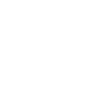

In [88]:
fig, ax = plt.subplots(1,1, figsize=(1, 1));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
margin = 130;
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.set_axis_off(); ax.margins(0,0);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
#ax.imshow(w01.Image)
#fig.savefig('./fig_v1/1a2.pdf', bbox_inches='tight')
#ax.imshow(m01.Image)
#fig.savefig('./fig_v1/1a3.pdf', bbox_inches='tight')

### 1a4

In [19]:
rs1 = np.zeros((4,8+2+2)); # from rep 1 folder, 0:wt1, 1:wt2, 2:mut1, 3: mut2
ts1 = np.zeros(12);
#rs2 = np.zeros((2, 6));
#ts2 = np.zeros(6);
for i in np.arange(12): # first deal with rep1
    t = 0;
    if(i < 8):
        dw1 = dir0+'1015/MONO1/W1_01_'+str(i+1)+'.tif';
        dw2 = dir0+'1015/MONO1/W2_01_'+str(i+1)+'.tif';
        dm1 = dir0+'1015/MONO1/M1_01_'+str(i+1)+'.tif';
        dm2 = dir0+'1015/MONO1/M2_01_'+str(i+1)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
    elif(i in [8,9]):
        dw1 = dir0+'1016/MONO1/W1_01_'+str(i-7)+'.tif';
        dw2 = dir0+'1016/MONO1/W2_01_'+str(i-7)+'.tif';
        dm1 = dir0+'1016/MONO1/M1_01_'+str(i-7)+'.tif';
        dm2 = dir0+'1016/MONO1/M2_01_'+str(i-7)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
    else:
        dw1 = dir0+'1017/MONO1/W1_01_'+str(i-9)+'.tif';
        dw2 = dir0+'1017/MONO1/W2_01_'+str(i-9)+'.tif';
        dm1 = dir0+'1017/MONO1/M1_01_'+str(i-9)+'.tif';
        dm2 = dir0+'1017/MONO1/M2_01_'+str(i-9)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
#ts1 = ts1 - ts1[0];
ts1 = ts1 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

In [18]:
rs2 = np.zeros((4, 6));
ts2 = np.zeros(6);
for i in np.arange(6): # first deal with rep1
    t = 0;
    if(i < 4):
        dw1 = dir0+'1015/MONO2/W1_01_'+str(i*2+1)+'.tif';
        dw2 = dir0+'1015/MONO2/W2_01_'+str(i*2+1)+'.tif';
        dm1 = dir0+'1015/MONO2/M1_01_'+str(i*2+1)+'.tif';
        dm2 = dir0+'1015/MONO2/M2_01_'+str(i*2+1)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
    elif(i ==4 ):
        dw1 = dir0+'1016/MONO2/W1_01_'+str(i-3)+'.tif';
        dw2 = dir0+'1016/MONO2/W2_01_'+str(i-3)+'.tif';
        dm1 = dir0+'1016/MONO2/M1_01_'+str(i-3)+'.tif';
        dm2 = dir0+'1016/MONO2/M2_01_'+str(i-3)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
    else:
        dw1 = dir0+'1017/MONO2/W1_01_'+str(i-4)+'.tif';
        dw2 = dir0+'1017/MONO2/W2_01_'+str(i-4)+'.tif';
        dm1 = dir0+'1017/MONO2/M1_01_'+str(i-4)+'.tif';
        dm2 = dir0+'1017/MONO2/M2_01_'+str(i-4)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
#ts2 = ts2 - ts2[0];
ts2 = ts2 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

In [407]:
ys1 = np.zeros((4,6));
ys2 = np.zeros((4,3));
yf = np.zeros((4,10));
xs1 = ts1[-6:]-ts1[0];
xs2 = ts2[-3:]-ts2[0];
for i in np.arange(4):
    ys1[i] = (rs1[i]*mpx)[-6:];
    ys2[i] = (rs2[i]*mpx)[-3:];
ys = np.concatenate([ys1, ys2], axis=-1);
xs = np.concatenate([xs1, xs2], axis=-1);
print(ys.shape)
for i in np.arange(4):
    sol = curve_fit(linf, xdata=xs, ydata=ys[i])
    yf[i] = np.linspace(0, 50, 10)*sol[0][0]+sol[0][1];
    print(sol[0][0], sol[1][0,0])

(4, 9)
0.03303634194847795 3.07809131975606e-07
0.030162623561544 1.5798744523832765e-06
0.022330397816478026 2.9286793667577705e-07
0.019917588615530803 2.488794067000923e-07


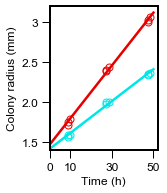

In [420]:
fig, ax = plt.subplots(figsize=(1.5,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.margins(0,0);
plt.setp(ax.get_yticklabels(), Fontsize=fsz);
plt.setp(ax.get_xticklabels(), Fontsize=fsz);

ax.errorbar(xs, ys[0], linestyle='none', marker='o', mfc='none', markersize=7, color=(0.9,0,0));
#ax.errorbar(xs, ys[1], linestyle='none', marker='o', mfc='none', markersize=10, color=(0,0.9,0.9));
#ax.errorbar(xs, ys[2], linestyle='none', marker='o', mfc='none', markersize=10, color=(0.9,0,0));
ax.errorbar(xs, ys[3], linestyle='none', marker='o', mfc='none', markersize=7, color=(0,0.9,0.9));
ax.plot(np.linspace(0,50,10), yf[0], color=(0.9,0,0), linewidth=2.5);
ax.plot(np.linspace(0,50,10), yf[3], color=(0,0.9,0.9), linewidth=2.5);
ax.set_xlim( 0,52 )
ax.set_ylim(1.4,3.2)
ax.set_xlabel('Time (h)',fontsize=fsz*1.5)
ax.set_yticks([1.5,2.,2.5,3]); ax.set_yticklabels([1.5,2.,2.5,3],fontsize=fsz*1.5)
ax.set_xticks([0,10,30,50]); ax.set_xticklabels([0,10,30,50],fontsize=fsz*1.5);
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*1.5)
#ax.legend([r'$34\ \mu m/hr$',r'$0.022\ {\rm mm/hr}$'], fontsize=fsz)

fig.savefig('./fig_v1/1a4.pdf', bbox_inches='tight')

## Fig. 1b

In [52]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

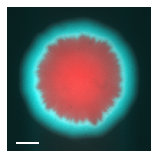

In [128]:
margin = 130;
fig, ax = plt.subplots(figsize=(2,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(comps[0,0]);
ax.set_axis_off(); ax.margins(0,0);
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
fig.savefig('./fig_v1/1b1.pdf', bbox_inches='tight')

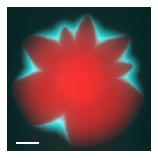

In [129]:
fig, ax = plt.subplots(figsize=(2,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(comps[2,0]);
ax.set_axis_off(); ax.margins(0,0);
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
fig.savefig('./fig_v1/1b2.pdf', bbox_inches='tight')

## Fig. 1c

In [20]:
dest1 = dir0+'1017/COMP0001/WM991_1_1.tif';
dest2 = dir0+'1017/COMP0001/WM991_2_1.tif';
comp = Colony([dest1,dest2]);

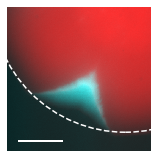

In [135]:
fig, ax = plt.subplots(1,1, figsize=(2, 2));
plt.rcParams.update({'font.size': fsz})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_axis_off()
img = np.copy(np.flip(comp.Image, axis=0));
ax.imshow( img )
ax.add_patch(patch.Circle( (512,512), 353, facecolor='none', edgecolor=(1,1,1),linestyle='--', linewidth=1.5 ))
#ax.add_patch(patch.FancyArrow( 420,340,0,-20, width=1, length_includes_head=True, head_width=2, color=(1,1,1), alpha=1  ))
s = 380;
ax.set_xlim(200,200+s); ax.set_ylim(110,110+s);
ax.plot( np.linspace(0, 1/mpx, 10)+ 230, np.ones(10)*135, color=(1,1,1), linewidth=2 )
#ax.text(350, 345, 'Mutant emerges', color=(1,1,1))
#ax.text(440, 450, 'Wildtype', color=(1,1,1))
fig.savefig('./fig_v1/1c.pdf', bbox_inches='tight')

## Fig. 3a

### 3a1

In [132]:
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C2.tif';
comp1 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C2.tif';
comp2 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C2.tif';
comp3 = Colony([dest1,dest2]);
t0= os.path.getmtime(dir0+'2020/0704/razor/start.txt');  
t = os.path.getmtime(dest1);  
print((t-t0)/3600)
#C:\Users\Hyun\Dropbox (MIT)\MRE_photos\photos\2020\0704\razor\T4\A1A2M_OD0001\10X

47.97888888888889


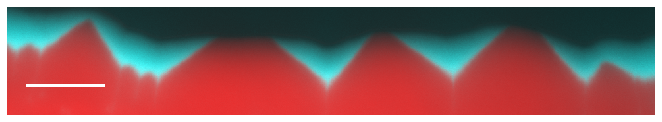

In [133]:
fig, ax = plt.subplots(1,1, figsize=(9, 1.5));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 20;
ax.set_xlim(margin,1024-margin); 
ax.set_ylim(575,575+(1024-margin*2)/6);
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow(comp2.Image)
ax.set_axis_off()
ax.plot( np.linspace(0, 1/mpx, 10)+50, np.ones(10)*620, color=(1,1,1), linewidth=3)
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/3a1.pdf', bbox_inches='tight')

In [10]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);

for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);


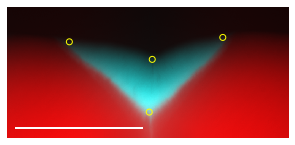

In [11]:
i=4;
fig, ax = plt.subplots(figsize=(5.1,5.17*7/15))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
#ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor=(1,1,1), linestyle='--') )

ax.scatter(xl,yl, color='none', edgecolor='yellow');
ax.scatter(xr,yr, color='none', edgecolor='yellow');
ax.scatter(xu,yu, color='none', edgecolor='yellow');
ax.scatter(xd,yd, color='none', edgecolor='yellow');

#ax.plot( np.ones(10)*517, np.linspace(750,900,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+910; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
#ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,770,r'$\phi_{\rm B}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*517, np.linspace(550,700,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+750; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
#ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,620,r'$\phi_{\rm D}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
#r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
#ys = ys[:95]; xs = xs[:95];
#ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
#ax.text(-0.04,3/15,'Mutant')
#ax.text(-0.05,-1/15,'Wildtype')
ax.plot( np.linspace(0, 4/mpx, 10)+30, np.ones(10)*920, color=(1,1,1), linewidth=2 )

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024*14/15,1024*7/15)
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/3a2.pdf', bbox_inches='tight')
#fig.savefig('1201_3c2_newc.png',bbox_inches='tight')

In [12]:
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
phid_expm4 = np.arctan( u/y )*180/np.pi
phis_expm4 = np.arctan( u/v2)*180/np.pi

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 

In [29]:
(20/33)**2/2-1

-0.8163452708907254

70.392$\pm$1.023 0.323742962977247
73.931$\pm$3.810 1.205066419396117


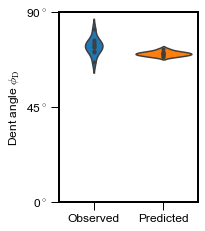

In [285]:
#####
mpl.rcParams['font.size'] = fsz*1.5;

fig, ax = plt.subplots(1,1,  figsize=(2.5, 3.5) )

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 
xs = np.concatenate([s2*0+1,s1*0+2]);
sns.violinplot( x=xs, y=np.concatenate([s2,s1]), inner='point', saturation=1, ax=ax )
print(np.str( np.average(s1) )[:6]+'$\pm$'+np.str( np.std(s1) )[:5], np.std(s1)/(10**0.5))
print(np.str( np.average(s2) )[:6]+'$\pm$'+np.str( np.std(s2) )[:5], np.std(s2)/(10**0.5))
#ax.text(1.6, 40, '70.4'+'$\pm$'+'1.0',fontsize=fsz*1.5)
#ax.text(0.6, 40, '73.9'+'$\pm$'+'3.8',fontsize=fsz*1.5)
ax.set_xticks([0,1]);
ax.set_xticklabels(['Observed','Predicted'] ,fontsize=fsz*1.5)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(0,90)
ax.set_ylabel('Dent angle '+r'$\phi_\mathrm{D}$', fontsize=fsz*1.5)
ax.set_yticks([0,45,90]);
ax.set_yticklabels(['0'+r'$^\circ$','45'+r'$^\circ$','90'+r'$^\circ$']);
ax.margins(0,0);
fig.savefig('./fig_v1/3c_b.pdf', bbox_inches='tight')

## Supplementary figure codes

### S1

In [452]:
imgs = np.zeros([2,11,1024,1024,3]);
for i in np.arange(2):
    for j in np.arange(9):
        if(j<3):
            dest = dir0+'2020/0704/Circle/';
            dest = dest + 'A'+str(i+1)+'_T4_'+str(j+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
            print(c.R*mpx)
        elif(j==3):
            dest = dir0+'0914/n1_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==4):
            dest = dir0+'0914/n2_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==5):
            dest = dir0+'0914/M1_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==6):
            dest = dir0+'0914/M2_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==7):
            dest = dir0+'0919/N1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==8):
            dest = dir0+'0919/N2/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==9):
            dest = dir0+'0919/M1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==10):
            dest = dir0+'0919/M2/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;

3.3180707302227157
3.345456808252846
3.3169451186959886
3.3892092087956445
3.449230876200335
3.399054771556792


In [447]:
imgs2 = np.zeros([2,4,1024,1024,3]);
imgs2[0] = imgs[0, 3:7];
imgs2[1] = imgs[1, 3:7];

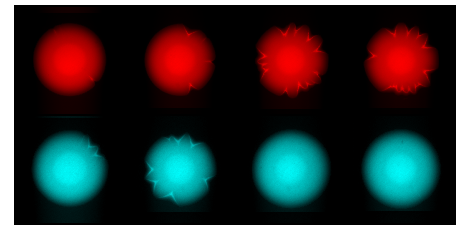

In [457]:
fig, ax = plt.subplots(2, 4, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(7.9,4) );
for i in np.arange(2):
    for j in np.arange(4):
        ax[i,j].imshow(imgs2[i,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s1a.pdf', bbox_inches='tight')

### S2

In [15]:
rs1 = np.zeros((4,8+2+2)); # from rep 1 folder, 0:wt1, 1:wt2, 2:mut1, 3: mut2
ts1 = np.zeros(12);
#rs2 = np.zeros((2, 6));
for i in np.arange(12): # first deal with rep1
    t = 0;
    if(i < 8):
        dw1 = dir0+'1015/MONO1/W1_01_'+str(i+1)+'.tif';
        dw2 = dir0+'1015/MONO1/W2_01_'+str(i+1)+'.tif';
        dm1 = dir0+'1015/MONO1/M1_01_'+str(i+1)+'.tif';
        dm2 = dir0+'1015/MONO1/M2_01_'+str(i+1)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ts1[i] = t;
    elif(i in [8,9]):
        dw1 = dir0+'1016/MONO1/W1_01_'+str(i-7)+'.tif';
        dw2 = dir0+'1016/MONO1/W2_01_'+str(i-7)+'.tif';
        dm1 = dir0+'1016/MONO1/M1_01_'+str(i-7)+'.tif';
        dm2 = dir0+'1016/MONO1/M2_01_'+str(i-7)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ts1[i] = t;
    else:
        dw1 = dir0+'1017/MONO1/W1_01_'+str(i-9)+'.tif';
        dw2 = dir0+'1017/MONO1/W2_01_'+str(i-9)+'.tif';
        dm1 = dir0+'1017/MONO1/M1_01_'+str(i-9)+'.tif';
        dm2 = dir0+'1017/MONO1/M2_01_'+str(i-9)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ts1[i] = t;
#ts1 = ts1 - ts1[0];
ts1 = ts1 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

In [16]:
rs2 = np.zeros((4, 6));
ts2 = np.zeros(6);
for i in np.arange(6): # first deal with rep1
    t = 0;
    if(i < 4):
        dw1 = dir0+'1015/MONO2/W1_01_'+str(i*2+1)+'.tif';
        dw2 = dir0+'1015/MONO2/W2_01_'+str(i*2+1)+'.tif';
        dm1 = dir0+'1015/MONO2/M1_01_'+str(i*2+1)+'.tif';
        dm2 = dir0+'1015/MONO2/M2_01_'+str(i*2+1)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ts2[i] = t;
    elif(i ==4 ):
        dw1 = dir0+'1016/MONO2/W1_01_'+str(i-3)+'.tif';
        dw2 = dir0+'1016/MONO2/W2_01_'+str(i-3)+'.tif';
        dm1 = dir0+'1016/MONO2/M1_01_'+str(i-3)+'.tif';
        dm2 = dir0+'1016/MONO2/M2_01_'+str(i-3)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ts2[i] = t;
    else:
        dw1 = dir0+'1017/MONO2/W1_01_'+str(i-4)+'.tif';
        dw2 = dir0+'1017/MONO2/W2_01_'+str(i-4)+'.tif';
        dm1 = dir0+'1017/MONO2/M1_01_'+str(i-4)+'.tif';
        dm2 = dir0+'1017/MONO2/M2_01_'+str(i-4)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ts2[i] = t;
ts2 = ts2 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

In [407]:
ys1 = np.zeros((4,6));
ys2 = np.zeros((4,3));
yf = np.zeros((4,10));
xs1 = ts1[-6:]-ts1[0];
xs2 = ts2[-3:]-ts2[0];
for i in np.arange(4):
    ys1[i] = (rs1[i]*mpx)[-6:];
    ys2[i] = (rs2[i]*mpx)[-3:];
ys = np.concatenate([ys1, ys2], axis=-1);
xs = np.concatenate([xs1, xs2], axis=-1);
print(ys.shape)
for i in np.arange(4):
    sol = curve_fit(linf, xdata=xs, ydata=ys[i])
    yf[i] = np.linspace(0, 50, 10)*sol[0][0]+sol[0][1];
    print(sol[0][0], sol[1][0,0])

(4, 9)
0.03303634194847795 3.07809131975606e-07
0.030162623561544 1.5798744523832765e-06
0.022330397816478026 2.9286793667577705e-07
0.019917588615530803 2.488794067000923e-07


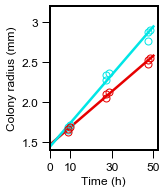

In [419]:
fig, ax = plt.subplots(figsize=(1.5,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.margins(0,0);
plt.setp(ax.get_yticklabels(), Fontsize=fsz);
plt.setp(ax.get_xticklabels(), Fontsize=fsz);

#ax.errorbar(xs, ys[0], linestyle='none', marker='o', mfc='none', markersize=10, color=(0.9,0,0));
ax.errorbar(xs, ys[1], linestyle='none', marker='o', mfc='none', markersize=7, color=(0,0.9,0.9));
ax.errorbar(xs, ys[2], linestyle='none', marker='o', mfc='none', markersize=7, color=(0.9,0,0));
#ax.errorbar(xs, ys[3], linestyle='none', marker='o', mfc='none', markersize=10, color=(0,0.9,0.9));
ax.plot(np.linspace(0,50,10), yf[2], color=(0.9,0,0), linewidth=2.5);
ax.plot(np.linspace(0,50,10), yf[1], color=(0,0.9,0.9), linewidth=2.5);
ax.set_xlim( 0,52 )
ax.set_ylim(1.4,3.2)
ax.set_xlabel('Time (h)',fontsize=fsz*1.5)
ax.set_yticks([1.5,2.,2.5,3]); ax.set_yticklabels([1.5,2.,2.5,3],fontsize=fsz*1.5)
ax.set_xticks([0,10,30,50]); ax.set_xticklabels([0,10,30,50],fontsize=fsz*1.5);
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*1.5)
#ax.legend([r'$34\ \mu m/hr$',r'$0.022\ {\rm mm/hr}$'], fontsize=fsz)

fig.savefig('./fig_v1/s2.pdf', bbox_inches='tight')

### S3

In [341]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
timages = np.zeros((10,3,1024,1024,3))
ts = np.zeros(10);
for i in np.arange(10):
    t = 0;
    if(i<5):
        dm = dir0+'1015/COMP01/WM991_2_'+str(i+1)+'.tif';
        dw = dir0+'1015/COMP01/WM991_1_'+str(i+1)+'.tif';
        w = Colony([dw]); t = os.path.getmtime(dw); 
        ts[i] = t/3600;
        continue;
    if(i<8):
        for j in np.arange(2):
            dm = dir0+'1015/COMP01/WM991_2_'+str(i+1)+'.tif';
            dw = dir0+'1015/COMP01/WM991_1_'+str(i+1)+'.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    elif(i<9):
         for j in np.arange(2):
            dm = dir0+'1016/COMP01/WM991_2_1.tif';
            dw = dir0+'1016/COMP01/WM991_1_1.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    else:
         for j in np.arange(2):
            dm = dir0+'1017/COMP01/WM991_2_1.tif';
            dw = dir0+'1017/COMP01/WM991_1_1.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    ts[i] = t/3600;

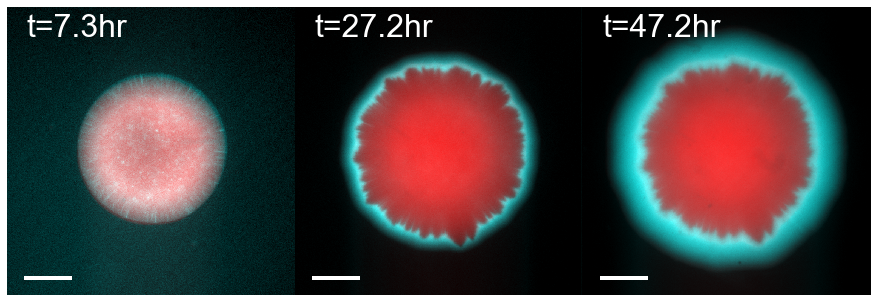

In [347]:
fig, ax = plt.subplots(1,3, figsize=(1*12, 1*4));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 130;


#img = np.zeros((1024,1024,3));
#for i in np.arange(3):
#    img[:,:,i] = comp0.Image[:,:,i]*filt
inds = [5,8,9];
for i in np.arange(3):
    ax[i].set_xlim(margin,1024-margin); ax[i].set_ylim(1024-margin,margin);
    ax[i].set_xticks([]); ax[i].set_yticks([]);
    ax[i].imshow(timages[inds[i],0]/np.max(timages[inds[i],0])+timages[inds[i],1]/np.max(timages[inds[i],1]))
    ax[i].set_axis_off()
    ax[i].plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
    ax[i].margins(0,0)
    ax[i].text( 50+margin, 80+margin, 't='+str(ts[inds[i]]-ts[0])[:3+inds[i]//7]+'hr', color=(1,1,1) )

fig.savefig('./fig_v1/s3c.pdf', bbox_inches='tight')


### S3

In [166]:
# competition outcome robust under color exchange

In [352]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

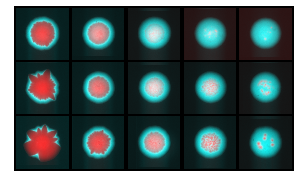

In [353]:
fig, ax = plt.subplots(3, 5, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(5,3) );
for i in np.arange(3):
    for j in np.arange(5):
        ax[i,j].imshow(comps[i,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s4.pdf', bbox_inches='tight')

### S5

In [166]:
# competition outcome robust under color exchange

In [424]:
str1 = ['01','001','0001'];
str2 = ['MW199','MW19','MW11','MW91','MW991'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif'], norm=False).Image;

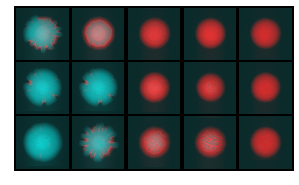

In [425]:
fig, ax = plt.subplots(3, 5, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(5,3) );
imgs = np.copy(comps);
imgs[:,:,:,:,1:]*=4;
for i in np.arange(3):
    for j in np.arange(5):
        ax[i,j].imshow(imgs[i,j]*4);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s5.pdf', bbox_inches='tight')